# Geokr

## Initialize

In [1]:
import json
from flickr import Flickr

with open('.config') as fp:
    config = json.load(fp)

flickr = Flickr(config['API_KEY'])

## Get photos

In [2]:
data = flickr.loadDataFromFile('dataTest.json')

# KMeans

### Get the coordinates from data

In [3]:
import numpy as np

coordinates = []

for photo in data:
    if photo["latitude"] != 0 and photo["longitude"] != 0:
        coordinates += [[photo["latitude"], photo["longitude"]]]

print "%d coordonnées" % len(coordinates)

coordinates = np.array(coordinates, dtype=float)

5115 coordonnées


### Run the algorithm

In [4]:
from scipy.cluster.vq import kmeans2

k = 10
i = 700

centroids, closest_centroids = kmeans2(coordinates, k, iter=i)

print centroids

[[ -18.67735168  -54.46820623]
 [  17.87659034  117.73629765]
 [  38.56900717   37.39083828]
 [  49.43574345   13.02733825]
 [  36.8299695   -95.76969503]
 [  52.30711638   -0.95232249]
 [ -35.06135494  151.61211572]
 [  39.29014441   -3.32990646]
 [ -22.15918589   30.13857403]
 [  21.33716511   78.74518538]]


### Filter by density

In [5]:
densities = [0] * k

for closest_centroid in closest_centroids:
    densities[closest_centroid - 1] += 1
    
print densities

filteredCentroids = centroids.tolist()

for i in range(len(densities) - 1, -1, -1):
    if densities[i] < 3 * len(data) / 100:
        filteredCentroids.remove(filteredCentroids[i])

filteredCentroids = np.array(filteredCentroids, dtype=float)
print filteredCentroids

[619, 211, 753, 1774, 718, 158, 293, 37, 123, 429]
[[ 49.43574345  13.02733825]]


## Plot

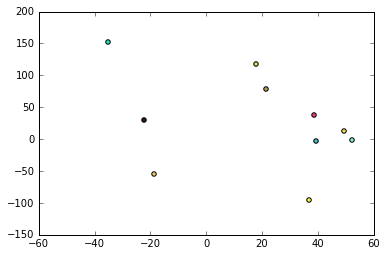

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

for centroid in centroids:
    plt.scatter(centroid[0], centroid[1], c=np.random.rand(3,1))
    
plt.show()

In [7]:
import folium
from IPython.display import HTML

def inline_map(m, width=800, height=600):
    """Takes a folium instance and embed HTML."""
    
    srcdoc = m._repr_html_().replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed


width, height = 800, 600
radars = folium.Map(location=[40, -122], zoom_start=1,
                    tiles='OpenStreetMap', width=width, height=height)

for centroid in centroids:
    folium.Marker([centroid[0], centroid[1]], ).add_to(radars) 



inline_map(radars)

### DBSCAN

In [8]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=10,min_samples=40).fit(coordinates)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print 'Estimated number of clusters: %d' % n_clusters_
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coordinates, db.labels_)

print "%d labels" % len(db.labels_)
print "%d coordinates" % len(coordinates)

Estimated number of clusters: 6
Silhouette Coefficient: 0.632
5115 labels
5115 coordinates


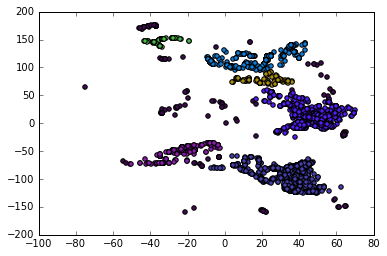

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(n_clusters_+1)]

i = 0
for label in db.labels_:
    plt.scatter(coordinates[i][0], coordinates[i][1], c=colors[(label+1)])
    i += 1
    
plt.show()

In [10]:
flickr = Flickr(config['API_KEY'])
photos = []
nb_page = 2
method = 'flickr.photos.search'
args = {
    'has_geo': 1,
    'per_page': 250,
    'extras': 'description,license,date_upload,date_taken,owner_name,icon_server,original_format,last_update,geo,tags,machine_tags,o_dims,views,media'
}

import json

for page in range(nb_page):
    args['page'] = page + 1
    photos += flickr.request(method, args)["photos"]["photo"]

                      centroid  count
0  1010.61538462-785.769230769     13
1  3502.33333333-5138.88888889      9
2  5391.21428571-3652.07142857     14
3  2993.94444444-2499.38888889     18
4  2084.13636364-1260.45454545     22
5                4417.4-3101.1     10


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
A variable was mapped to y.
    stat_bin sets the y value to the count of cases in each group.
    The mapping to y was ignored.
    If you want y to represent values in the data, use stat="bar".


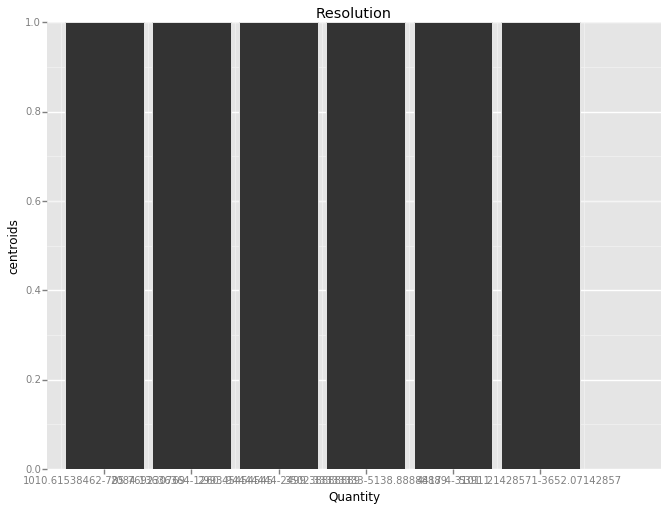

<ggplot: (277966485)>

In [11]:
from ggplot import *
import pandas as pd

dims = [[photo['o_width'],photo['o_height']] for photo in photos if photo.has_key('o_width') and photo.has_key('o_height')]

import numpy as np
from scipy.cluster.vq import kmeans2

k = 6
i = 500

centroids, closest_centroids = kmeans2(np.array(dims, dtype=float), k, iter=i)
count = [len([c for c in closest_centroids if c == i]) for i in range(len(centroids))];

df = pd.DataFrame({
    "count" : count,
    "centroid" : [str(c[0]) + "-" + str(c[1]) for c in centroids]
})

print df

ggplot(df, aes(x='centroid',y='count')) + geom_bar() + ggtitle("Resolution") + labs("Quantity", "centroids")

## Convert centroids to GeoJSON

In [12]:
import json

def getFeature(coordinates):
    return {
        "type": "Feature",
        "properties" : {},
        "geometry" : {
            "type" : "Point",
            "coordinates" : [coordinates[1], coordinates[0]]
        }
    }

features = [getFeature(coordinates) for coordinates in centroids]

geoJson = {
    "type" : "FeatureCollection",
    "features" : features
}

print json.dumps(geoJson)

{"type": "FeatureCollection", "features": [{"geometry": {"type": "Point", "coordinates": [785.76923076923072, 1010.6153846153846]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [5138.8888888888887, 3502.3333333333335]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [3652.0714285714284, 5391.2142857142853]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2499.3888888888887, 2993.9444444444443]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [1260.4545454545455, 2084.1363636363635]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [3101.0999999999999, 4417.3999999999996]}, "type": "Feature", "properties": {}}]}
